# COGS 118B Final Project

## Pre-reqs

In [1]:
# required imports

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

# do not show warning for division by 0
_ = np.seterr(divide='ignore', invalid='ignore')

## Exploring the Data

In [2]:
# import dataset and display it

data = pd.read_csv('data.csv', encoding='cp1252').drop('Index', axis=1)
original_size = len(data)

data

,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,Heartbreak Hotel,Elvis Presley,adult standards,1958,94,21,70,-12,11,72,128,84,7,63
1990,Hound Dog,Elvis Presley,adult standards,1958,175,76,36,-8,76,95,136,73,6,69
1991,Johnny B. Goode,Chuck Berry,blues rock,1959,168,80,53,-9,31,97,162,74,7,74
1992,Take Five,The Dave Brubeck Quartet,bebop,1959,174,26,45,-13,7,60,324,54,4,65


In [3]:
# check for missing data

print(f'There are {data.isnull().sum().sum()} missing values.')

There are 0 missing values.


The following features from the dataset will be used for clustering:

1 - Beats Per Minute (BPM)
2 - Energy
3 - Danceability
4 - Loudness (dB)
5 - Liveness
6 - Valence
7 - Acousticness
8 - Speechiness


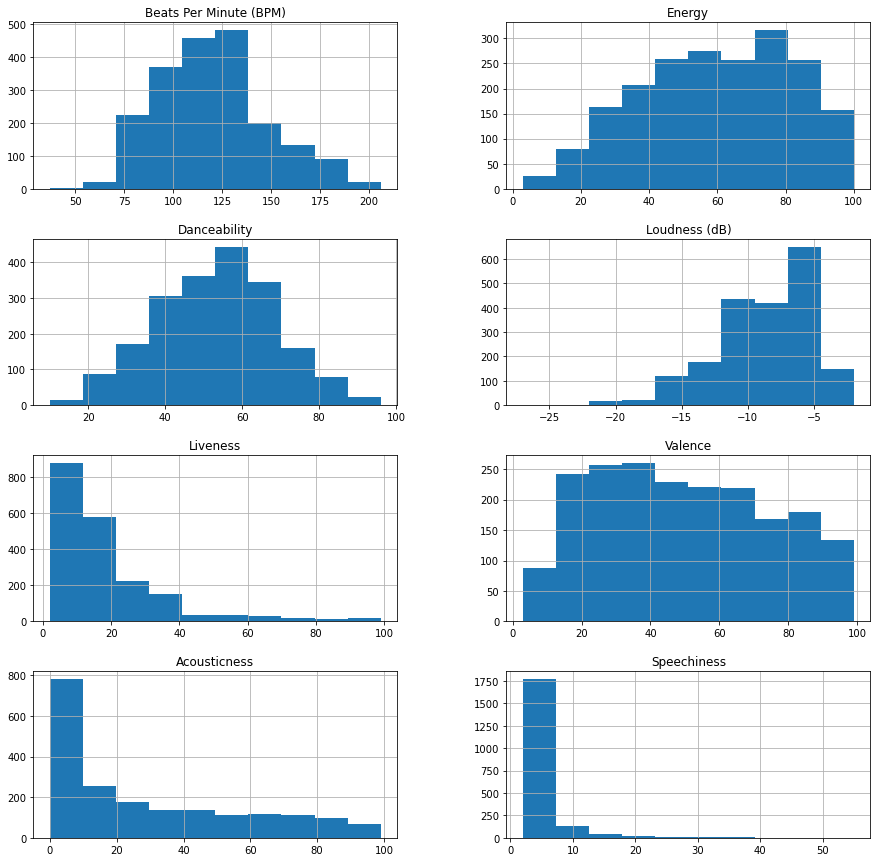

In [4]:
# extract audio features relevant to clustering and display them with their distribution

features = list(data.columns[4:13])
del features[6]

print('The following features from the dataset will be used for clustering:\n')

for i, feature in enumerate(features):
    print(f'{i + 1} - {feature}')
    
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
fig = data.hist(column=features, ax=axes)

In [5]:
# extract the genres and display them

def get_genres():
    return sorted(data['Top Genre'].unique(), reverse = True, 
                  key = lambda genre: len(data.loc[data['Top Genre'] == genre]))

def display_genres():
    genres = get_genres()
    
    print(f'Displaying {len(genres)} genres.\n')
    
    longest_length = len(max(genres, key = len))
    
    print(f'{"idx":{3}} | {"genres":^{longest_length}} | {"# entries":^{3}}\n' + '-' * (longest_length + 18))
    
    for i, genre in enumerate(genres):
        num = len(data.loc[data['Top Genre'] == genre])
        print(f'{i + 1:<{3}} | {genre:{longest_length}} | {num:<{9}}')
    
display_genres()

Displaying 149 genres.

idx |           genres            | # entries
---------------------------------------------
1   | album rock                  | 413      
2   | adult standards             | 123      
3   | dutch pop                   | 88       
4   | alternative rock            | 86       
5   | dance pop                   | 83       
6   | dutch indie                 | 75       
7   | alternative metal           | 70       
8   | dance rock                  | 52       
9   | classic rock                | 51       
10  | dutch cabaret               | 51       
11  | modern rock                 | 49       
12  | glam rock                   | 49       
13  | pop                         | 47       
14  | art rock                    | 40       
15  | permanent wave              | 38       
16  | british invasion            | 36       
17  | irish rock                  | 34       
18  | british soul                | 31       
19  | europop                     | 27       
20  | clas

## Preparing the Data

In [6]:
# 149 genres leads to too many clusters. we reduce this number in two ways:
# 1: group similar genres together (ie: 'album rock' and 'alternative rock' are grouped under 'rock')
# 2: only pick the most represented genres in the dataset

# 1
def group_genres(groups):
    for group in groups:
        data.loc[[group in genre for genre in data['Top Genre']], 'Top Genre'] = group

group_genres(['rock', 'pop', 'indie', 'hip hop', 'soul', 'metal', 'country', 'folk', 'jazz', 'elec', 'dance'])

# 2 (only keep genres with more than 20 songs)
top_genres = [genre for genre in get_genres() if len(data.loc[data['Top Genre'] == genre]) > 20]
data = data[data['Top Genre'].isin(top_genres)]

display_genres()

print(f'\nThe dataset now has {len(data)} entries.\n{original_size - len(data)} entries were removed, ' +
       'keeping only songs that belong in a genre with 10 or more songs. ')

data

Displaying 10 genres.

idx |      genres      | # entries
----------------------------------
1   | rock             | 857      
2   | pop              | 388      
3   | adult standards  | 123      
4   | metal            | 93       
5   | indie            | 79       
6   | dutch cabaret    | 51       
7   | soul             | 45       
8   | permanent wave   | 38       
9   | british invasion | 36       
10  | hip hop          | 29       

The dataset now has 1739 entries.
255 entries were removed, keeping only songs that belong in a genre with 10 or more songs. 


,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,Black Night,Deep Purple,rock,2000,135,79,50,-11,17,81,207,17,7,39
2,Clint Eastwood,Gorillaz,hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,The Pretender,Foo Fighters,metal,2007,173,96,43,-4,3,37,269,0,4,76
4,Waitin' On A Sunny Day,Bruce Springsteen,rock,2002,106,82,58,-5,10,87,256,1,3,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,Summertime,Louis Armstrong,adult standards,1958,168,7,17,-21,14,10,298,92,3,66
1989,Heartbreak Hotel,Elvis Presley,adult standards,1958,94,21,70,-12,11,72,128,84,7,63
1990,Hound Dog,Elvis Presley,adult standards,1958,175,76,36,-8,76,95,136,73,6,69
1991,Johnny B. Goode,Chuck Berry,rock,1959,168,80,53,-9,31,97,162,74,7,74


## Principal Component Analysis

In [7]:
characteristics_columns=list(data.columns[4:13])
del characteristics_columns[6]
characteristics_columns

['Beats Per Minute (BPM)',
 'Energy',
 'Danceability',
 'Loudness (dB)',
 'Liveness',
 'Valence',
 'Acousticness',
 'Speechiness']

In [8]:
characteristics_matrix = data[characteristics_columns].to_numpy().transpose()
c_matrix=characteristics_matrix # to shorten this name
print(c_matrix)
print(c_matrix.shape)

[[157 135 168 ... 175 168 133]
 [ 30  79  69 ...  76  80  50]
 [ 53  50  66 ...  36  53  49]
 ...
 [ 68  81  52 ...  95  97  83]
 [ 94  17   2 ...  73  74  74]
 [  3   7  17 ...   6   7   3]]
(8, 1739)


### eigsort.m from HW 4

In [9]:
# [Vsort,Dsort] = eigsort(V, eigvals)
#
# Sorts a matrix eigenvectors and a array of eigenvalues in order 
# of eigenvalue size, largest eigenvalue first and smallest eigenvalue
# last.
#
# Example usage:
# di, V = np.linarg.eig(L)
# Vnew, Dnew = eigsort(V, di)
#
# Tim Marks 2002
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

In [10]:
def pca(data_matrix, characteristics):
    c_matrix = data_matrix
    mean_c = np.mean(c_matrix, axis=1, keepdims=True)
    c_standardized=c_matrix-mean_c
    cov_matrix=np.matmul(c_standardized, c_standardized.transpose())/7
    dold, vold = np.linalg.eig(cov_matrix)
    v, d = eigsort(vold, dold)
    new_c_matrix = np.matmul(v[:,0:3].transpose(), c_standardized)
    return new_c_matrix, v, d

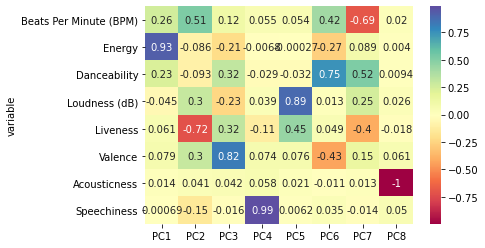

In [11]:
new_c_matrix, v, d = pca(c_matrix, characteristics_columns)
num_pc = 8
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
v_df = pd.DataFrame.from_dict(dict(zip(pc_list, v)))
v_df['variable'] = characteristics_columns
v_df = v_df.set_index('variable')
ax = sns.heatmap(v_df, annot=True, cmap='Spectral')
plt.show()

0.8110442520522395
0.8997375913102003


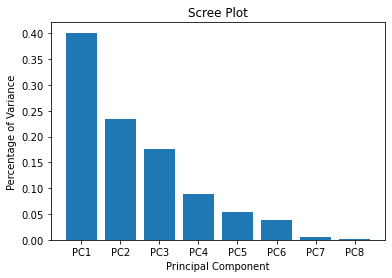

In [12]:
index_values = np.arange(8)+1
normalized_variability = d.diagonal()/sum(d.diagonal())
plt.bar(index_values,normalized_variability)
plt.title('Scree Plot');
plt.xlabel('Principal Component');
plt.ylabel('Percentage of Variance');
plt.xticks(index_values, pc_list);
print(normalized_variability[0]+normalized_variability[1]+normalized_variability[2])
print(normalized_variability[0]+normalized_variability[1]+normalized_variability[2]+normalized_variability[3])

From the Scree plot we can see that the first 3-4 components have the largest effect on the variability of the data, so we should focus on using those for further analysis. The first 3 make up 81.1% of the variability, while the first 4 make up 90.1% of the variability, well above the recommended 80% threshold.

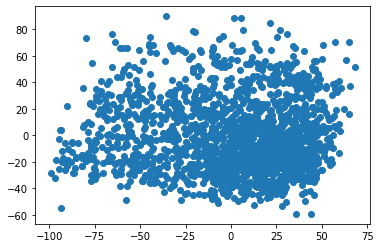

In [13]:
plt.scatter(new_c_matrix[0], new_c_matrix[1]);

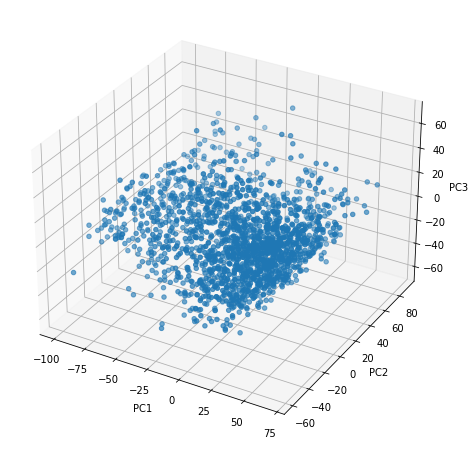

In [14]:
fig = plt.figure(figsize=(8,8));
axes = fig.add_subplot(projection='3d');
axes.scatter(new_c_matrix[0], new_c_matrix[1], new_c_matrix[2]);
axes.set_xlabel('PC1');
axes.set_ylabel('PC2');
axes.set_zlabel('PC3');

## K - Means

In [15]:
def k_means(k, feats):
    final_rnk = None
    prev_centroids = None

    centroids_idxs = [random.randrange(0, len(feats), 1) for i in range(k)]
    centroids = np.array([f for i, f in enumerate(feats) if i in centroids_idxs])
    
    while True:
        dist_mat = cdist(feats, centroids)
        rnk = np.array([np.amin(dist_mat, axis = 1)] * len(dist_mat[0])).T == dist_mat

        prev_centroids = centroids
        centroids = (np.matmul(feats.T, rnk).T / 
                     np.array([np.sum(rnk, axis = 0)] * len(feats[0])).T)
                
        if abs(np.nansum(centroids - prev_centroids)) < 1e-6 :
            final_rnk = rnk
            break
    
    return np.sort([np.count_nonzero(np.argmax(final_rnk, axis = 1) == i) for i in range(k)])[::-1]


def print_cluster_counts():
    print(f'{"idx":{3}} | {"# in cluster"} \n' + '-' * (18))
    
    for i, c in enumerate(cluster_counts):
        print(f'{i:^3} | {c:^14}')

In [16]:
cluster_counts = k_means(np.array(len(top_genres)), np.array(data[features].values.tolist()))
print_cluster_counts()

idx | # in cluster 
------------------
 0  |      237      
 1  |      231      
 2  |      213      
 3  |      181      
 4  |      179      
 5  |      172      
 6  |      156      
 7  |      145      
 8  |      140      
 9  |       85      


In [17]:
cluster_counts = k_means(np.array(len(top_genres)), np.array(data[['Beats Per Minute (BPM)', 'Energy', 'Liveness']].values.tolist()))
print_cluster_counts()

idx | # in cluster 
------------------
 0  |      276      
 1  |      229      
 2  |      213      
 3  |      212      
 4  |      170      
 5  |      160      
 6  |      142      
 7  |      125      
 8  |      113      
 9  |       99      
